### **Import Libraries**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress all logs except warnings

from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import (make_scorer, accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from interpret.glassbox import ExplainableBoostingClassifier
from ngboost import NGBClassifier
from snapml import BoostingMachineClassifier
from tab_transformer_pytorch import TabTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import lightgbm as lgb

from skopt import BayesSearchCV
from ray import tune
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

from sklearn.base import BaseEstimator, ClassifierMixin

### **Load & Split Data**

In [2]:
df = pd.read_csv('../data/cleaned_data.csv')

print('Sample Data')
display(df.head())

Sample Data


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,0,0,0,0,1,0
1,55,0,156,85.0,140,90,2,0,0,0,1,1
2,51,0,165,64.0,130,70,2,0,0,0,0,1
3,48,1,169,82.0,150,100,0,0,0,0,1,1
4,60,0,151,67.0,120,80,1,1,0,0,0,0


In [3]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

In [4]:
label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

### **Scaling Data**

In [5]:
standard_features = ['age', 'height', 'weight','ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)

In [6]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

,age,height,weight,ap_hi,ap_lo,gender,cholesterol,gluc,smoke,alco,active
0,-0.430687,0.441395,-0.868717,-1.155855,-0.231849,1.0,0.0,0.0,0.0,0.0,1.0
1,0.310810,-1.067843,0.760886,0.929802,1.064795,0.0,2.0,0.0,0.0,0.0,1.0
2,-0.282387,0.064086,-0.727012,0.234583,-1.528493,0.0,2.0,0.0,0.0,0.0,0.0
3,-0.727286,0.567165,0.548329,1.625020,2.361439,1.0,0.0,0.0,0.0,0.0,1.0
4,1.052307,-1.696692,-0.514455,-0.460636,-0.231849,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
64464,0.607409,0.064086,0.406625,1.625020,-0.231849,0.0,0.0,0.0,0.0,0.0,1.0
64465,-0.134088,0.441395,0.123215,-0.460636,-0.231849,1.0,0.0,0.0,1.0,0.0,1.0
64466,1.200607,-0.816303,3.665832,0.929802,1.064795,0.0,1.0,1.0,0.0,0.0,1.0
64467,1.200607,-0.187454,-0.160194,0.582192,-0.231849,0.0,0.0,1.0,0.0,0.0,0.0


### **Train, Val, Test**

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)  # Train 70%
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%

In [8]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

### **Base Model**

#### Hyperparameter Tuning (Optuna)

#### **Explainable Boosting Machine (EBM)**

Best Parameters: {'learning_rate': 0.0014, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 0.75, 'outer_bags': 8, 'greedy_ratio': 0.0, 'min_samples_leaf': 4, 'smoothing_rounds': 50, 'max_rounds': 10000, 'early_stopping_rounds': 100}
Best Validation Accuracy: 0.7350705754614549
EBM Accuracy with Best Parameters: 0.7231

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.77      0.74      3261
 Cardio Risk       0.74      0.68      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.72      0.72      0.72      6447
weighted avg       0.72      0.72      0.72      6447



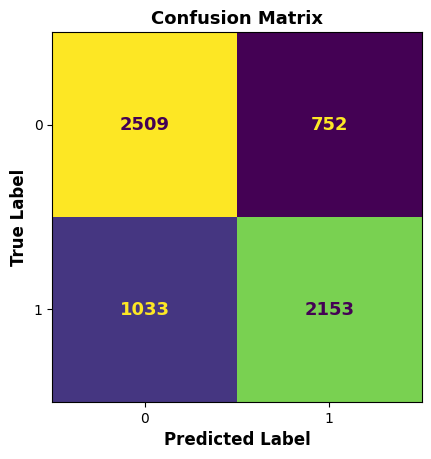

In [ ]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.02, step=0.005)
    max_bins = trial.suggest_int("max_bins", 256, 512, step=256)
    max_interaction_bins = trial.suggest_int("max_interaction_bins", 32, 64, step=32)
    interactions = trial.suggest_float("interactions", 0.0, 0.75, step=0.25)
    outer_bags = trial.suggest_int("outer_bags", 8, 16, step=8)
    greedy_ratio = trial.suggest_float("greedy_ratio", 0.0, 10.0, step=5.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 4, step=2)
    smoothing_rounds = trial.suggest_int("smoothing_rounds", 25, 50, step=25)
    max_rounds = trial.suggest_int("max_rounds", 5000, 10000, step=5000)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 50, 100, step=50)

    model = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        max_interaction_bins=max_interaction_bins,
        interactions=interactions,
        outer_bags=outer_bags,
        greedy_ratio=greedy_ratio,
        min_samples_leaf=min_samples_leaf,
        smoothing_rounds=smoothing_rounds,
        max_rounds=max_rounds,
        early_stopping_rounds=early_stopping_rounds,
        random_state=42,
    )

    model.fit(x_train, y_train)
    
    y_val_pred = model.predict(x_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
base_model_ebm = ExplainableBoostingClassifier(
    learning_rate=best_params["learning_rate"],
    max_bins=best_params["max_bins"],
    max_interaction_bins=best_params["max_interaction_bins"],
    interactions=best_params["interactions"],
    outer_bags=best_params["outer_bags"],
    greedy_ratio=best_params["greedy_ratio"],
    min_samples_leaf=best_params["min_samples_leaf"],
    smoothing_rounds=best_params["smoothing_rounds"],
    max_rounds=best_params["max_rounds"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    random_state=42,
)
base_model_ebm.fit(x_train, y_train)

y_test_pred = base_model_ebm.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"EBM Accuracy with Best Parameters: {test_accuracy:.4f}")

report = classification_report(y_test, y_test_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_ebm.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()


Best Parameters: {'learning_rate': 0.015, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 0.25, 'outer_bags': 16, 'greedy_ratio': 5.0, 'min_samples_leaf': 2, 'smoothing_rounds': 25, 'max_rounds': 10000, 'early_stopping_rounds': 50}
Best Validation Accuracy: 0.7299015647624315
EBM Accuracy with Best Parameters: 0.7222

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.71      0.77      0.74      3261
 Cardio Risk       0.74      0.68      0.71      3186

    accuracy                           0.72      6447
   macro avg       0.72      0.72      0.72      6447
weighted avg       0.72      0.72      0.72      6447



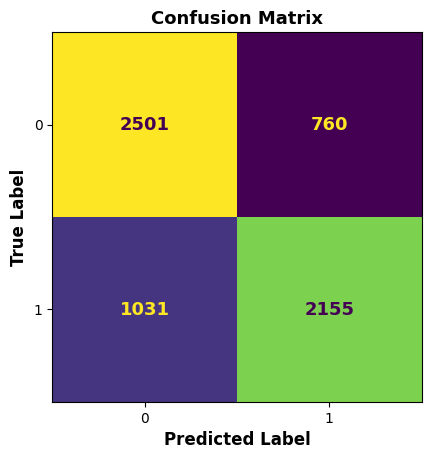

In [10]:
from sklearn.model_selection import cross_val_score

# Fungsi untuk optimasi hyperparameter
def objective(trial):
    # 1. Saran parameter hyperparameter
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.02, step=0.005)
    max_bins = trial.suggest_int("max_bins", 256, 512, step=256)
    max_interaction_bins = trial.suggest_int("max_interaction_bins", 32, 64, step=32)
    interactions = trial.suggest_float("interactions", 0.0, 0.75, step=0.25)
    outer_bags = trial.suggest_int("outer_bags", 8, 16, step=8)
    greedy_ratio = trial.suggest_float("greedy_ratio", 0.0, 10.0, step=5.0)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 4, step=2)  # Regularisasi melalui leaf
    smoothing_rounds = trial.suggest_int("smoothing_rounds", 25, 50, step=25)
    max_rounds = trial.suggest_int("max_rounds", 5000, 10000, step=5000)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 50, 100, step=50)

    # 2. Model ExplainableBoostingClassifier
    model = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        max_interaction_bins=max_interaction_bins,
        interactions=interactions,
        outer_bags=outer_bags,
        greedy_ratio=greedy_ratio,
        min_samples_leaf=min_samples_leaf,  # Membantu regularisasi
        smoothing_rounds=smoothing_rounds,
        max_rounds=max_rounds,
        early_stopping_rounds=early_stopping_rounds,
        random_state=42,
    )

    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    val_accuracy = scores.mean() 

    return val_accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
base_model_ebm = ExplainableBoostingClassifier(
    learning_rate=best_params["learning_rate"],
    max_bins=best_params["max_bins"],
    max_interaction_bins=best_params["max_interaction_bins"],
    interactions=best_params["interactions"],
    outer_bags=best_params["outer_bags"],
    greedy_ratio=best_params["greedy_ratio"],
    min_samples_leaf=best_params["min_samples_leaf"],
    smoothing_rounds=best_params["smoothing_rounds"],
    max_rounds=best_params["max_rounds"],
    early_stopping_rounds=best_params["early_stopping_rounds"],
    random_state=42,
)
base_model_ebm.fit(x_train, y_train)

y_test_pred = base_model_ebm.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"EBM Accuracy with Best Parameters: {test_accuracy:.4f}")

report = classification_report(y_test, y_test_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_ebm.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()


In [19]:
y_test_pred = base_model_ebm.predict(x_train)
test_accuracy = accuracy_score(y_train, y_test_pred)
print(f"EBM Accuracy with Best Parameters: {test_accuracy:.4f}")

EBM Accuracy with Best Parameters: 0.7313


#### **NGBoost**

In [49]:
class NGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.ngb = NGBClassifier(**kwargs)
        self.classes_ = None

    def fit(self, X, y):
        self.ngb.fit(X, y)
        self.classes_ = np.unique(y) 
        return self

    def predict(self, X):
        return self.ngb.predict(X)

    def predict_proba(self, X):
        return self.ngb.predict_proba(X)

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    minibatch_frac = trial.suggest_float("minibatch_frac", 0.1, 1.0)
    col_sample = trial.suggest_float("col_sample", 0.1, 1.0)

    model = NGBClassifierWrapper(
        Dist=Bernoulli,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        minibatch_frac=minibatch_frac,
        col_sample=col_sample
    )

    model.fit(x_train_np, y_train_np)

    y_pred = model.predict(x_test_np)
    accuracy = accuracy_score(y_test_np, y_pred)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=3600)

print("Best hyperparameters:")
print(study.best_params)

best_params = study.best_params
base_model_ngb = NGBClassifierWrapper(
    Dist=Bernoulli,
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    minibatch_frac=best_params["minibatch_frac"],
    col_sample=best_params["col_sample"]
)

base_model_ngb.fit(x_train_np, y_train_np)
y_pred = base_model_ngb.predict(x_test)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Optimized NGBClassifier Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_ngb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()


[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5582 val_loss=0.0000 scale=2.0000 norm=3.7695
[iter 200] loss=0.5503 val_loss=0.0000 scale=2.0000 norm=3.8935
[iter 300] loss=0.5495 val_loss=0.0000 scale=2.0000 norm=3.9509
[iter 400] loss=0.5415 val_loss=0.0000 scale=1.0000 norm=1.9638
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5504 val_loss=0.0000 scale=2.0000 norm=3.8262
[iter 200] loss=0.5499 val_loss=0.0000 scale=1.0000 norm=1.9643
[iter 300] loss=0.5440 val_loss=0.0000 scale=2.0000 norm=3.9314
[iter 400] loss=0.5422 val_loss=0.0000 scale=2.0000 norm=3.9373
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5410 val_loss=0.0000 scale=2.0000 norm=3.9443
[iter 200] loss=0.5403 val_loss=0.0000 scale=1.0000 norm=1.9822
[iter 300] loss=0.5388 val_loss=0.0000 scale=1.0000 norm=1.9871
[iter 400] loss=0.5344 val_loss=0.0000 scale=1.0000 norm=1.9772
[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0

[W 2025-01-21 15:25:11,007] Trial 10 failed with parameters: {'n_estimators': 313, 'learning_rate': 0.34821763034038666, 'minibatch_frac': 0.17173149499344809, 'col_sample': 0.5142092291645832} because of the following error: LinAlgError('Singular matrix').
Traceback (most recent call last):
  File "/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10295/2215775020.py", line 31, in objective
    model.fit(x_train_np, y_train_np)
  File "/tmp/ipykernel_10295/2215775020.py", line 7, in fit
    self.ngb.fit(X, y)
  File "/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/ngboost/ngboost.py", line 250, in fit
    return self.partial_fit(
  File "/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/ngboost/ngboost.py", line 383, in partial_fit
    grads = D.grad(Y_batch, natural=self.natura

LinAlgError: Singular matrix

#### **SnapBoost**

In [ ]:
def objective(trial):
    num_round = trial.suggest_int("num_round", 50, 200, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, step=0.01)
    max_depth = trial.suggest_int("max_depth", 3, 10, step=1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1)

    model = BoostingMachineClassifier(
        num_round=num_round,
        learning_rate=learning_rate,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        random_state=42,
        verbose=False,
    )

    model.fit(x_train_np, y_train_np)
    y_pred = model.predict(x_test_np)
    accuracy = accuracy_score(y_test_np, y_pred)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
base_model_snb = BoostingMachineClassifier(
    num_round=best_params["num_round"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    colsample_bytree=best_params["colsample_bytree"],
    subsample=best_params["subsample"],
    random_state=42,
    verbose=False,
)
base_model_snb.fit(x_train_np, y_train_np)

y_pred = base_model_snb.predict(x_test_np)
test_accuracy = accuracy_score(y_test_np, y_pred)
print(f"SnapBoost Accuracy with Best Parameters: {test_accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_snb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()


SnapBoost Accuracy: 0.7242


#### **TabNet**

In [ ]:
def objective(trial):
    n_d = trial.suggest_int("n_d", 8, 64, step=8)  
    n_a = trial.suggest_int("n_a", 8, 64, step=8)  
    n_steps = trial.suggest_int("n_steps", 3, 10, step=1) 
    gamma = trial.suggest_float("gamma", 1.0, 2.0, step=0.1) 
    lambda_sparse = trial.suggest_float("lambda_sparse", 0.00001, 0.001, log=True)  
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, step=0.01)
    max_epochs = 25  
    
    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=learning_rate),
        seed=42,
    )

    model.fit(
        x_train_np, y_train_np,
        eval_set=[(x_test_np, y_test_np)],
        eval_metric=["accuracy"],
        max_epochs=max_epochs,
        patience=10,
        verbose=0,
    )

    y_pred = model.predict(x_test_np)
    accuracy = accuracy_score(y_test_np, y_pred)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
base_model_tabnet = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params=dict(lr=best_params["learning_rate"]),
    seed=42,
)
base_model_tabnet.fit(
    x_train_np, y_train_np,
    eval_set=[(x_train_np, y_train_np)],
    eval_metric=["accuracy"],
    max_epochs=25,
    patience=10,
    verbose=1,
)

y_pred = base_model_tabnet.predict(x_test_np)
test_accuracy = accuracy_score(y_test_np, y_pred)
print(f"TabNet Accuracy with Best Parameters: {test_accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model_tabnet.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

epoch 0  | loss: 0.61783 | val_0_accuracy: 0.71763 |  0:00:01s
epoch 1  | loss: 0.56573 | val_0_accuracy: 0.72285 |  0:00:02s
epoch 2  | loss: 0.56013 | val_0_accuracy: 0.72348 |  0:00:03s
epoch 3  | loss: 0.55764 | val_0_accuracy: 0.72352 |  0:00:05s
epoch 4  | loss: 0.55687 | val_0_accuracy: 0.72622 |  0:00:06s
epoch 5  | loss: 0.55642 | val_0_accuracy: 0.7268  |  0:00:07s
epoch 6  | loss: 0.55412 | val_0_accuracy: 0.72605 |  0:00:09s
epoch 7  | loss: 0.55303 | val_0_accuracy: 0.72802 |  0:00:10s
epoch 8  | loss: 0.55386 | val_0_accuracy: 0.72735 |  0:00:11s
epoch 9  | loss: 0.55315 | val_0_accuracy: 0.72822 |  0:00:13s
epoch 10 | loss: 0.55321 | val_0_accuracy: 0.72795 |  0:00:14s
epoch 11 | loss: 0.55237 | val_0_accuracy: 0.72811 |  0:00:15s
epoch 12 | loss: 0.55274 | val_0_accuracy: 0.72897 |  0:00:16s
epoch 13 | loss: 0.55249 | val_0_accuracy: 0.7282  |  0:00:18s
epoch 14 | loss: 0.55191 | val_0_accuracy: 0.72899 |  0:00:19s
epoch 15 | loss: 0.55224 | val_0_accuracy: 0.72935 |  0

#### **TabTransformer**

In [ ]:
categorical_indices = [5, 6, 7, 8, 9, 10]  # Indices of categorical features
continuous_indices = [0, 1, 2, 3, 4]       # Indices of continuous features

class TabTransformerWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, categories, num_continuous, dim=32, depth=4, heads=4, dim_out=1, lr=0.001, epochs=5, batch_size=64):
        self.categories = categories
        self.num_continuous = num_continuous
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_out = dim_out
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = None

    def _initialize_model(self):
        from tab_transformer_pytorch import TabTransformer
        self.model = TabTransformer(
            categories=self.categories,
            num_continuous=self.num_continuous,
            dim=self.dim,
            depth=self.depth,
            heads=self.heads,
            dim_out=self.dim_out
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self._initialize_model()

        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        dataset = torch.utils.data.TensorDataset(x_categ, x_cont, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for batch_x_categ, batch_x_cont, batch_y in dataloader:
                self.optimizer.zero_grad()
                preds = self.model(batch_x_categ, batch_x_cont).squeeze()
                loss = self.loss_fn(preds, batch_y)
                loss.backward()
                self.optimizer.step()

        self.classes_ = np.array([0, 1])
        return self

    def predict(self, X):
        X = np.asarray(X)
        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return (torch.sigmoid(preds) > 0.5).cpu().numpy().astype(int)

    def predict_proba(self, X):
        X = np.asarray(X)
        x_categ = torch.tensor(X[:, categorical_indices], dtype=torch.long).to(self.device)
        x_cont = torch.tensor(X[:, continuous_indices], dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x_categ, x_cont).squeeze()
        return np.column_stack((1 - torch.sigmoid(preds).cpu().numpy(), torch.sigmoid(preds).cpu().numpy()))

def objective(trial):
    dim = trial.suggest_int("dim", 16, 64, step=16)
    depth = trial.suggest_int("depth", 2, 6)
    heads = trial.suggest_int("heads", 2, 8, step=2)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 128, step=32)
    epochs = 5 

    model = TabTransformerWrapper(
        categories=[2, 3, 3, 2, 2, 2],
        num_continuous=len(continuous_indices),
        dim=dim,
        depth=depth,
        heads=heads,
        dim_out=1,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
    )

    model.fit(x_train_np, y_train_np)
    y_pred = model.predict(x_test_np)
    accuracy = accuracy_score(y_test_np, y_pred)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
base_model_tabtf = TabTransformerWrapper(
    categories=[2, 3, 3, 2, 2, 2],
    num_continuous=len(continuous_indices),
    dim=best_params["dim"],
    depth=best_params["depth"],
    heads=best_params["heads"],
    dim_out=1,
    lr=best_params["lr"],
    epochs=5,
    batch_size=best_params["batch_size"],
)
base_model_tabtf.fit(x_train_np, y_train_np)

y_pred = base_model_tabtf.predict(x_test_np)
test_accuracy = accuracy_score(y_test_np, y_pred)
print(f"Test Accuracy with Best Parameters: {test_accuracy:.4f}")

TabTransformer Accuracy: 0.6710


#### **Meta Model**

In [ ]:
def objective(trial):
    num_leaves = trial.suggest_int("num_leaves", 15, 50, step=5)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, step=0.01)
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    subsample = trial.suggest_float("subsample", 0.6, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0, step=0.1)

    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
    )

    model.fit(x_train_np, y_train_np, eval_set=[(x_train_np, y_train_np)])
    y_pred = model.predict(x_test_np)
    accuracy = accuracy_score(y_test_np, y_pred)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

best_params = study.best_params
meta_model_lgb = lgb.LGBMClassifier(
    num_leaves=best_params["num_leaves"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    reg_alpha=best_params["reg_alpha"],
    reg_lambda=best_params["reg_lambda"],
    random_state=42,
)
meta_model_lgb.fit(x_train_np, y_train_np)

y_pred = meta_model_lgb.predict(x_test_np)
accuracy = accuracy_score(y_test_np, y_pred)
print(f"\nMeta-Model Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta_model_lgb.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()

#### **Stacking Model**

In [ ]:
base_models = [
    ("ebc", base_model_ebm), ("ngb", base_model_ngb), ('snb', base_model_snb), 
    ('tabnet', base_model_tabnet), ('tabtf', base_model_tabtf)
]

In [ ]:
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model_lgb
)

In [ ]:
stacking_model.fit(x_train_np, y_train_np)

[iter 0] loss=0.6931 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5587 val_loss=0.0000 scale=2.0000 norm=3.7921
[iter 200] loss=0.5491 val_loss=0.0000 scale=2.0000 norm=3.8779
[iter 300] loss=0.5460 val_loss=0.0000 scale=2.0000 norm=3.9110
[iter 400] loss=0.5443 val_loss=0.0000 scale=1.0000 norm=1.9657
epoch 0  | loss: 0.61783 |  0:00:00s
epoch 1  | loss: 0.56487 |  0:00:01s
epoch 2  | loss: 0.56014 |  0:00:02s
epoch 3  | loss: 0.55756 |  0:00:03s
epoch 4  | loss: 0.55684 |  0:00:04s
epoch 5  | loss: 0.55691 |  0:00:05s
epoch 6  | loss: 0.5552  |  0:00:06s
epoch 7  | loss: 0.55603 |  0:00:07s
epoch 8  | loss: 0.5556  |  0:00:08s
epoch 9  | loss: 0.55526 |  0:00:08s
epoch 10 | loss: 0.55473 |  0:00:09s
epoch 11 | loss: 0.5535  |  0:00:10s
epoch 12 | loss: 0.55359 |  0:00:11s
epoch 13 | loss: 0.55269 |  0:00:12s
epoch 14 | loss: 0.55382 |  0:00:12s
epoch 15 | loss: 0.55219 |  0:00:13s
epoch 16 | loss: 0.55244 |  0:00:14s
epoch 17 | loss: 0.55188 |  0:00:15s
epoch 18 | loss:

StackingClassifier(estimators=[('ebc', ExplainableBoostingClassifier()),
                               ('ngb', NGBClassifierWrapper()),
                               ('snb',
                                BoostingMachineClassifier(max_depth=5,
                                                          random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=42,
                                                 clip...ue=1,
                                                 verbose=1,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},
                                                 mask_type='sparsemax',
                                                 input_dim=11,
                                                 output_dim=2,
                                                 device_name='auto',
                                                 n_shared_decoder=1,
                                                 n_indep_decoder=1,
                                                 grouped_features=[])),
                               ('tabtf',
                                TabTransformerWrapper(categories=[2, 3, 3, 2, 2,
                                                                  2],
                                                      num_continuous=5))],
                   final_estimator=SVC())

In [ ]:
y_pred = stacking_model.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.4f}")

report = classification_report(y_test_np, y_pred, target_names=target_names)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(y_test_np, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_model.classes_)
disp.plot(cmap='viridis', colorbar=False, text_kw={'fontsize': 13, 'fontweight': 'bold'})
plt.title("Confusion Matrix", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
plt.ylabel("True Label", fontsize=12, fontweight='bold')
plt.show()